In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold

pd.options.mode.chained_assignment = None

In [47]:
housing = pd.read_csv("AmesHousing.tsv", delimiter='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [48]:
def transform_features(train):
    df = train.copy()
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    text_cols = df.select_dtypes(exclude=[np.number]).columns
    
    num_nas = df[num_cols].isnull().sum()
    text_nas = df[text_cols].isnull().sum()
    
    na_over_025 = [n for n in num_nas.index if num_nas[n]>0.25*len(df)]
    df = df.drop(labels=na_over_025, axis=1)
    
    na_below_005 = [n for n in num_nas.index if num_nas[n]<0.05*len(df)]
    df[na_below_005].fillna(stats.mode, inplace=True) 
    
    na_over_one = [n for n in text_nas.index if text_nas[n]>0]
    df = df.drop(labels=na_over_one, axis=1) 
    
    df['Years Before Sold'] = df['Yr Sold'] - df['Year Built']
        
    ## Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)
    
    ## Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

def select_features(train):
    return train.columns[train.columns != 'SalePrice']

def train_and_test(df, folds):
    features = select_features(df)
    
    kf = KFold(folds, shuffle=True, random_state=1)
    model = LinearRegression()
    mses = cross_val_score(model, df[features], df["SalePrice"],
                           scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)    
    
#     train = df.iloc[:1460]
#     test = df.iloc[1460:]
    
    
#     model = LinearRegression()
#     model.fit(train[features], train['SalePrice'])
    
#     predictions = model.predict(test[features])
    
#     mse = mean_squared_error(test['SalePrice'], predictions)
    
    print("Average RMSE:", avg_rmse)
    
    return avg_rmse, std_rmse

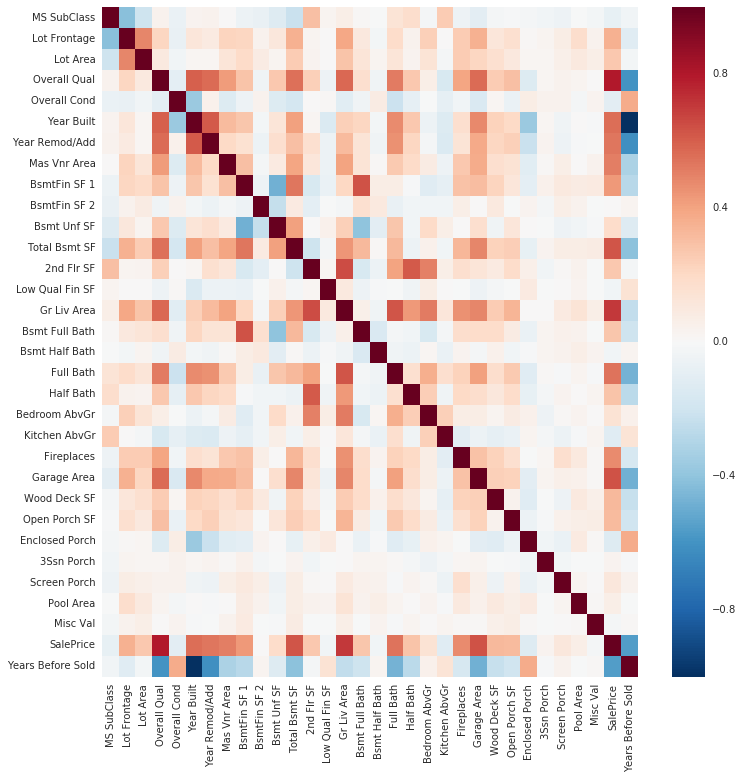

In [49]:
df = transform_features(housing)

# drop highly correlated columns
df = df.drop(['Garage Yr Blt', '1st Flr SF', 'TotRms AbvGrd', 'Garage Cars'], 
             axis=1, errors='ignore')

fig = plt.figure(figsize=(12,12))

ax = sns.heatmap(df.select_dtypes(include=[np.number]).corr())

fig.add_axes(ax)

plt.show()

In [50]:
price_corr = df.select_dtypes(include=[np.number]).corr()['SalePrice']

for c in price_corr:
    if c<0.25:
        df = df.drop(c, axis=1, errors='ignore')    
        
df.columns        

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Area',
       'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice',
       'Years Before Sold'],
      dtype='object')

In [51]:
nominals_full = ['MS SubClass', 'MS Zoning', 'Street', 
                 'Alley', 'Land Contour', 'Lot Config', 
                 'Neighborhood', 'Condition 1', 'Condition 2',
                 'Bldg Type', 'House Style', 'Roof Style', 
                 'Roof Matl', 'Exterior 1', 'Exterior 2',
                 'Mas Vnr Type', 'Foundation', 'Heating', 
                 'Central Air', 'Garage Type', 'Misc Feature',
                 'Sale Type', 'Sale Condition', 'Exterior 1st',
                'Exterior 2nd']

# filter out features left after drop
nominals = list(set(nominals_full).intersection(set(df.columns.tolist())))

X = pd.get_dummies(df[nominals])
Y = df['SalePrice']

model = ExtraTreesClassifier()
model.fit(X, Y)

importances = pd.Series(data=model.feature_importances_, index=X.columns)
importances.sort_values(inplace=True, ascending=False)

cats = importances[importances>.005].index.tolist()

print(cats)

['MS SubClass', 'Lot Config_Inside', 'Lot Config_Corner', 'Condition 1_Norm', 'Roof Style_Gable', 'House Style_1Story', 'Roof Style_Hip', 'Lot Config_CulDSac', 'Foundation_CBlock', 'Land Contour_Lvl', 'Condition 1_Feedr', 'Neighborhood_NAmes', 'Exterior 1st_Wd Sdng', 'Foundation_BrkTil', 'House Style_2Story', 'House Style_1.5Fin', 'Neighborhood_Edwards', 'Exterior 2nd_Wd Sdng', 'Neighborhood_OldTown', 'Exterior 2nd_Plywood', 'Exterior 2nd_HdBoard', 'Exterior 1st_HdBoard', 'Foundation_PConc', 'Exterior 1st_MetalSd', 'Lot Config_FR2', 'Neighborhood_Sawyer', 'Neighborhood_CollgCr', 'Exterior 2nd_MetalSd', 'Land Contour_Bnk', 'Neighborhood_Mitchel', 'Bldg Type_1Fam', 'Exterior 1st_VinylSd', 'MS Zoning_RL', 'House Style_SLvl', 'Neighborhood_BrkSide', 'Exterior 1st_Plywood', 'Neighborhood_NWAmes', 'Exterior 2nd_VinylSd', 'Exterior 2nd_Wd Shng', 'Condition 1_Artery', 'Bldg Type_TwnhsE', 'MS Zoning_RM', 'Exterior 1st_BrkFace', 'House Style_SFoyer', 'Neighborhood_SawyerW', 'Neighborhood_Timber'

In [52]:
ordianls_full = ['Lot Shape', 'Utilities', 'Land Slope',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual',
                'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
                'BsmtFinType 2', 'HeatingQC', 'Electrical',
                 'KitchenQual', 'Functional', 'FireplaceQu',
                'Garage Finish', 'Garage Qual', 'Garage Cond'
                'Paved Drive', 'Pool QC', 'Fence',
                 'Kitchen Qual', 'Heating QC']

ordinals = list(set(ordianls_full).intersection(set(df.columns.tolist())))

ordinals_vals = [5, 4, 3, 2, 1, 0]
ordinals_to_replace = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

df[ordinals].replace(to_replace=ordinals_to_replace, value=ordinals_vals, inplace=True)

for c in ordinals:
    if df[c].dtype!=np.int64:
        df = df.drop(c, axis=1, errors='ignore')        

In [53]:
# 'Paved Drive' column only
ordinals_vals = [2, 1, 0]
ordinals_to_replace = ['Y', 'P', 'N']

df['Paved Drive'].replace(to_replace=ordinals_to_replace, value=ordinals_vals, inplace=True)

df['Paved Drive'].value_counts()

2    2652
0     216
1      62
Name: Paved Drive, dtype: int64

In [54]:
df = df.drop(nominals, axis=1, errors='ignore') 
df = pd.concat([df, X[cats]], axis=1)
df.columns

Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Fireplaces', 'Garage Area', 'Paved Drive', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'SalePrice', 'Years Before Sold',
       'MS SubClass', 'Lot Config_Inside', 'Lot Config_Corner',
       'Condition 1_Norm', 'Roof Style_Gable', 'House Style_1Story',
       'Roof Style_Hip', 'Lot Config_CulDSac', 'Foundation_CBlock',
       'Land Contour_Lvl', 'Condition 1_Feedr', 'Neighborhood_NAmes',
       'Exterior 1st_Wd Sdng', 'Foundation_BrkTil', 'House Style_2Story',
       'House Style_1.5Fin', 'Neighborhood_Edwards', 'Exterior 2nd_Wd Sdng',
       'Neighborhood_O

In [55]:
def find_col_by_val(val):
    col_name = ''
    found=False
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if df.iloc[i,j]==val:
                col_name = df.columns[j]
                found=True
            if found:
                break
        if found:
            break
            
    return col_name

# Finds column name by value:

# col_name = find_col_by_val('Gd')
# if col_name!='':
#     print(df[col_name].value_counts())

In [56]:
cols = df.isnull().sum()[df.isnull().sum()>0]
print("Columns with nulls before:", cols)

for c in cols.index.values:
    df[c].fillna(df[c].mode()[0], inplace=True)
    
print("after:", df.isnull().sum()[df.isnull().sum()>0])

Columns with nulls before: Lot Frontage      490
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Area         1
dtype: int64
after: Series([], dtype: int64)


In [57]:
rmse = train_and_test(df, 5)

Average RMSE: 31288.7715449
